# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Read in the data for all years
df = pd.read_csv('data/data_with_years.csv')
df.head()

,SEQN,Year,Diabetes,Age,LDL Chol,HDL Chol,Chloride,Total Chol,GGT,AST,Hemoglobin,Weight,BMI,ALP,ALT
0,1.0,1999-2000,0,2,108.710285,53.277988,103.345424,183.944825,26.740553,24.945995,13.806845,12.5,14.900000,87.745839,23.851419
1,2.0,1999-2000,0,77,136.000000,53.277988,104.500000,215.000000,20.000000,19.000000,14.100000,75.4,24.900000,62.000000,16.000000
2,3.0,1999-2000,0,10,58.000000,53.277988,103.345424,129.000000,26.740553,24.945995,13.700000,32.9,17.630000,87.745839,23.851419
3,4.0,1999-2000,0,1,108.710285,53.277988,103.345424,183.944825,26.740553,24.945995,9.300000,13.3,25.494282,87.745839,23.851419
4,5.0,1999-2000,0,49,168.000000,53.277988,98.900000,279.000000,34.000000,22.000000,14.500000,92.5,29.100000,63.000000,28.000000


In [3]:
df[['Year']].value_counts().sort_index()

Year     
1999-2000     9483
2001-2002    10467
2003-2004     9638
2005-2006     9813
2007-2008     9657
2009-2010    10103
2011-2012     9357
2013-2014     9763
2015-2016     9571
2017-2018     8893
dtype: int64

In [4]:
#Creating a dictionary of the dataframes for each cycle
year_range = ['1999-2000','2001-2002','2003-2004','2005-2006','2007-2008','2009-2010','2011-2012','2013-2014','2015-2016','2017-2018']

df_dict = {}
for year in year_range:
    df_name = 'df_' + year
    df_dict[df_name] = df[df['Year'] == year]

In [5]:
#keys for each dataframe in dictionary
df_dict.keys()

dict_keys(['df_1999-2000', 'df_2001-2002', 'df_2003-2004', 'df_2005-2006', 'df_2007-2008', 'df_2009-2010', 'df_2011-2012', 'df_2013-2014', 'df_2015-2016', 'df_2017-2018'])

In [25]:
df.columns

Index(['Diabetes', 'Age', 'LDL Chol', 'HDL Chol', 'Chloride', 'Total Chol',
       'GGT', 'AST', 'Hemoglobin', 'Weight', 'BMI', 'ALP', 'ALT'],
      dtype='object')

## Logistic Regression

### Control Variables

##### Fitting models with Control Variables for each cycle

In [26]:
#This creates a logistic regression model for each cycle and storing the feature importances, MSEs in a dictionary

feature_importance_dict = {}
mse_dict = {}
perf_metrics = {}
for key, value in df_dict.items():
    df = value.drop(['SEQN','Year'], axis=1)
    X = df[['Age','BMI','Weight']]
    y = df[['Diabetes']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #reshape y_train to be a column vector
    y_train = y_train.values.ravel()
    #Logistic Regression
    logistic = LogisticRegression(max_iter=1000)
    pipe = Pipeline([('logistic', logistic)])
    param_grid = {'logistic__C': np.logspace(-3, 3, 7)}
    logistic_model = GridSearchCV(pipe, param_grid, cv=5)
    logistic_model.fit(X_train, y_train)
    #feature importance
    feature_import = abs(logistic_model.best_estimator_.steps[0][1].coef_)
    feature_import = 100 * feature_import / feature_import.sum()
    feature_importance_dict[key] = feature_import[0]
    mse_dict[key] = {'Train MSE': round(mean_squared_error(y_train,logistic_model.predict(X_train)),4),
                    'Test MSE': round(mean_squared_error(y_test,logistic_model.predict(X_test)),4)}
    perf_metrics[key] = {'F1': round(f1_score(y_test,logistic_model.predict(X_test)),4),
                        'Precision': round(precision_score(y_test,logistic_model.predict(X_test)),4),
                        'Recall': round(recall_score(y_test,logistic_model.predict(X_test)),4)}

c:\Users\jbrad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


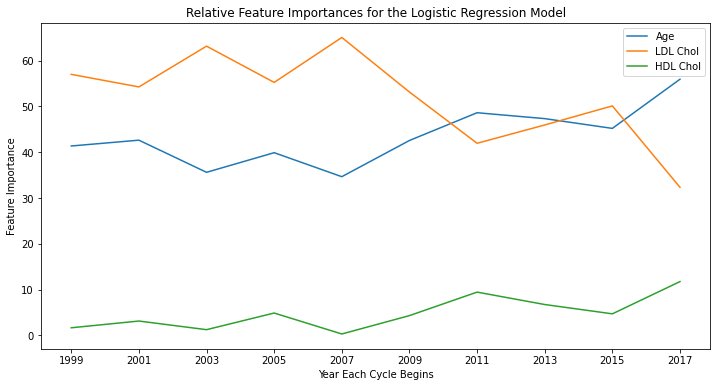

In [27]:
#plot feature importances for the logistic model over each cycle
plt.figure(figsize=(12,6))
plt.plot(['1999','2001','2003','2005','2007','2009','2011','2013','2015','2017'],feature_importance_dict.values())
plt.title('Relative Feature Importances for the Logistic Regression Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Feature Importance')
plt.legend(feature_names)
plt.show()

#HDL spiked in the 2003 cycle and then stayed relatively low for the rest of the cycles
#Hemoglobin was lower in the first two cycles and then stayed at the top of the range for the rest of the cycles

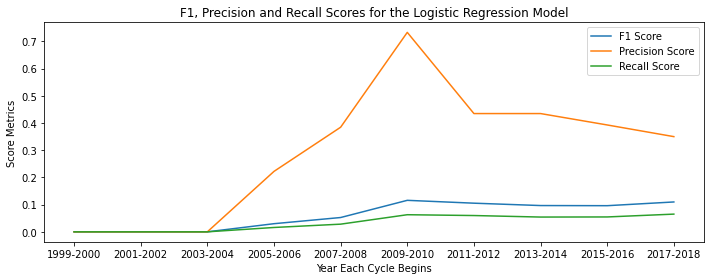

In [29]:
#plotting F1, Precision and Recall for the logistic regression model over each cycle
f1_list = []
precision_list = []
recall_list = []
cycle_list = []
for cycle, cycle_v in perf_metrics.items():
    for k, v in cycle_v.items():
        if k == 'F1':
            f1_list.append(v)
        elif k == 'Precision':
            precision_list.append(v)
        elif k == 'Recall':
            recall_list.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, f1_list, label='F1 Score')
plt.plot(cycle_list, precision_list, label='Precision Score')
plt.plot(cycle_list, recall_list, label='Recall Score')
plt.title('F1, Precision and Recall Scores for the Logistic Regression Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Score Metrics')
plt.legend()
plt.tight_layout()
plt.show()

### Full Model

##### Fitting models for each cycle

In [6]:
#This creates a logistic regression model for each cycle and storing the feature importances, MSEs in a dictionary

feature_importance_dict = {}
mse_dict = {}
perf_metrics = {}
for key, value in df_dict.items():
    df = value.drop(['SEQN','Year'], axis=1)
    X = df.drop('Diabetes', axis=1)
    y = df[['Diabetes']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #reshape y_train to be a column vector
    y_train = y_train.values.ravel()
    #Logistic Regression
    logistic = LogisticRegression(max_iter=1000)
    pipe = Pipeline([('logistic', logistic)])
    param_grid = {'logistic__C': np.logspace(-3, 3, 7)}
    logistic_model = GridSearchCV(pipe, param_grid, cv=5)
    logistic_model.fit(X_train, y_train)
    #feature importance
    feature_import = abs(logistic_model.best_estimator_.steps[0][1].coef_)
    feature_import = 100 * feature_import / feature_import.sum()
    feature_importance_dict[key] = feature_import[0]
    mse_dict[key] = {'Train MSE': round(mean_squared_error(y_train,logistic_model.predict(X_train)),4),
                    'Test MSE': round(mean_squared_error(y_test,logistic_model.predict(X_test)),4)}
    perf_metrics[key] = {'F1': round(f1_score(y_test,logistic_model.predict(X_test)),4),
                        'Precision': round(precision_score(y_test,logistic_model.predict(X_test)),4),
                        'Recall': round(recall_score(y_test,logistic_model.predict(X_test)),4)}

In [7]:
#Creating feature names for graphs
feature_names = logistic_model.best_estimator_.steps[0][1].feature_names_in_
feature_names

array(['Age', 'LDL Chol', 'HDL Chol', 'Chloride', 'Total Chol', 'GGT',
       'AST', 'Hemoglobin', 'Weight', 'BMI', 'ALP', 'ALT'], dtype=object)

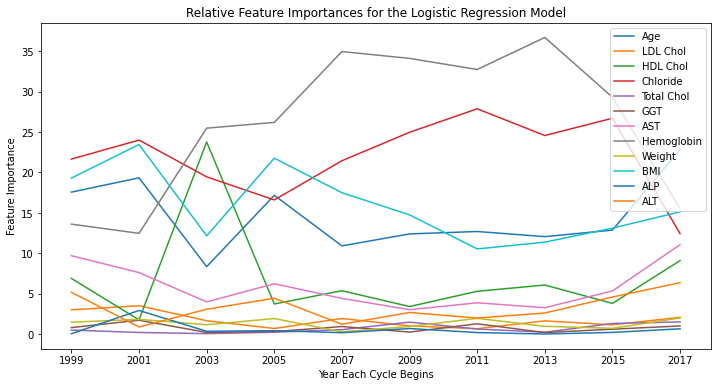

In [8]:
#plot feature importances for the logistic model over each cycle
plt.figure(figsize=(12,6))
plt.plot(['1999','2001','2003','2005','2007','2009','2011','2013','2015','2017'],feature_importance_dict.values())
plt.title('Relative Feature Importances for the Logistic Regression Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Feature Importance')
plt.legend(feature_names)
plt.show()

#HDL spiked in the 2003 cycle and then stayed relatively low for the rest of the cycles
#Hemoglobin was lower in the first two cycles and then stayed at the top of the range for the rest of the cycles

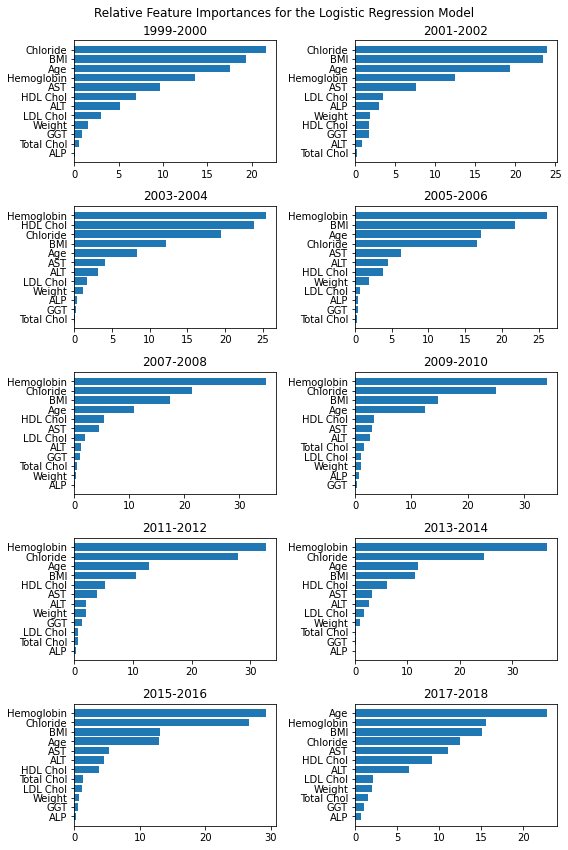

In [9]:
#Creating barcharts showing feature importances for the Logistic Regression Model for each cycle
fig, ax = plt.subplots(5,2, figsize=(8,12))

for a, (k,v) in zip(ax.flatten(), feature_importance_dict.items()):
        feat_importances = pd.Series(v,feature_names).sort_values(ascending=False)
        a.barh(feat_importances.index[::-1], feat_importances.values[::-1])
        a.set(title=k.strip('df_'))
        plt.tight_layout()
        fig.suptitle('Relative Feature Importances for the Logistic Regression Model')

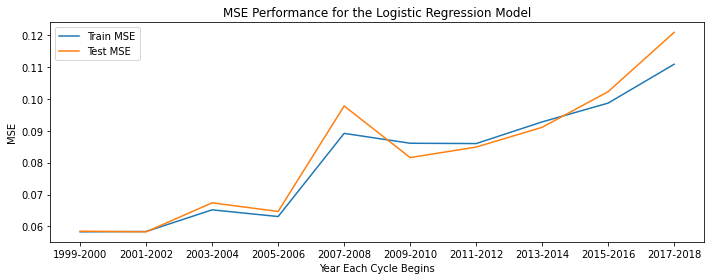

In [10]:
#plotting MSEs for the logistic regression model over each cycle for the train and test sets
train_mse = []
test_mse = []
cycle_list = []
for cycle, cycle_v in mse_dict.items():
    for k, v in cycle_v.items():
        if k == 'Train MSE':
            train_mse.append(v)
        elif k == 'Test MSE':
            test_mse.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, train_mse, label='Train MSE')
plt.plot(cycle_list, test_mse, label='Test MSE')
plt.title('MSE Performance for the Logistic Regression Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

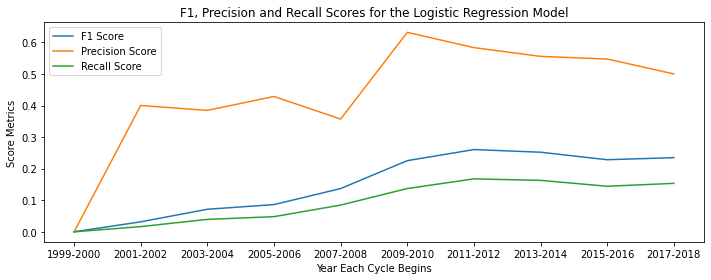

In [11]:
#plotting F1, Precision and Recall for the logistic regression model over each cycle
f1_list = []
precision_list = []
recall_list = []
cycle_list = []
for cycle, cycle_v in perf_metrics.items():
    for k, v in cycle_v.items():
        if k == 'F1':
            f1_list.append(v)
        elif k == 'Precision':
            precision_list.append(v)
        elif k == 'Recall':
            recall_list.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, f1_list, label='F1 Score')
plt.plot(cycle_list, precision_list, label='Precision Score')
plt.plot(cycle_list, recall_list, label='Recall Score')
plt.title('F1, Precision and Recall Scores for the Logistic Regression Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Score Metrics')
plt.legend()
plt.tight_layout()
plt.show()

## Support Vector Machines

In [12]:
#This creates a support vector machines model for each cycle and storing the feature importances, MSEs in a dictionary
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

feature_importance_dict = {}
mse_dict = {}
perf_metrics = {}
for key, value in df_dict.items():
    df = value.drop(['SEQN','Year'], axis=1)
    X = df.drop('Diabetes', axis=1)
    y = df[['Diabetes']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #reshape y_train to be a column vector
    y_train = y_train.values.ravel()
    ##Support Vector Machines
    svm = SVC(kernel='linear', max_iter=1000)
    pipe = Pipeline([('scaler',StandardScaler()),('svm', svm)])
    param_grid = {'svm__C': np.logspace(-3, 3, 7)}
    #param_grid = {'svm__C': [0.01, 0.1]}
    svm_model = GridSearchCV(pipe, param_grid, cv=5)
    svm_model.fit(X_train, y_train)
    #feature importance
    feature_import = abs(svm_model.best_estimator_[1].coef_)
    feature_import = 100 * feature_import / feature_import.sum()
    feature_importance_dict[key] = feature_import[0]
    mse_dict[key] = {'Train MSE': round(mean_squared_error(y_train,svm_model.predict(X_train)),4),
                    'Test MSE': round(mean_squared_error(y_test,svm_model.predict(X_test)),4)}
    perf_metrics[key] = {'F1': round(f1_score(y_test,svm_model.predict(X_test)),4),
                        'Precision': round(precision_score(y_test,svm_model.predict(X_test),zero_division=1),4),
                        'Recall': round(recall_score(y_test,svm_model.predict(X_test)),4)}

In [13]:
#Creating feature names for graphs
feature_names = svm_model.best_estimator_.steps[0][1].feature_names_in_
feature_names

array(['Age', 'LDL Chol', 'HDL Chol', 'Chloride', 'Total Chol', 'GGT',
       'AST', 'Hemoglobin', 'Weight', 'BMI', 'ALP', 'ALT'], dtype=object)

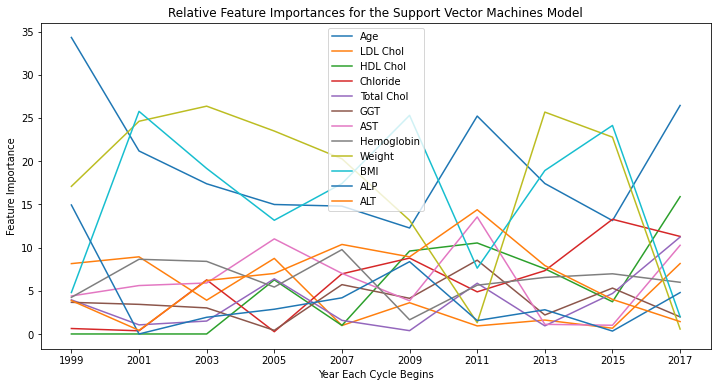

In [14]:
#plot feature importances for the SVM model over each cycle
plt.figure(figsize=(12,6))
plt.plot(['1999','2001','2003','2005','2007','2009','2011','2013','2015','2017'],feature_importance_dict.values())
plt.title('Relative Feature Importances for the Support Vector Machines Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Feature Importance')
plt.legend(feature_names)
plt.show()

#Differing substantially from the Logist Regression model, the Random Forest model had the top 2 feature importances (Age and BMI) stay
# in the top 2 positions throughout the cycles.
#There was some shifting near the bottom but the top 2 features stayed in the top 2 positions.

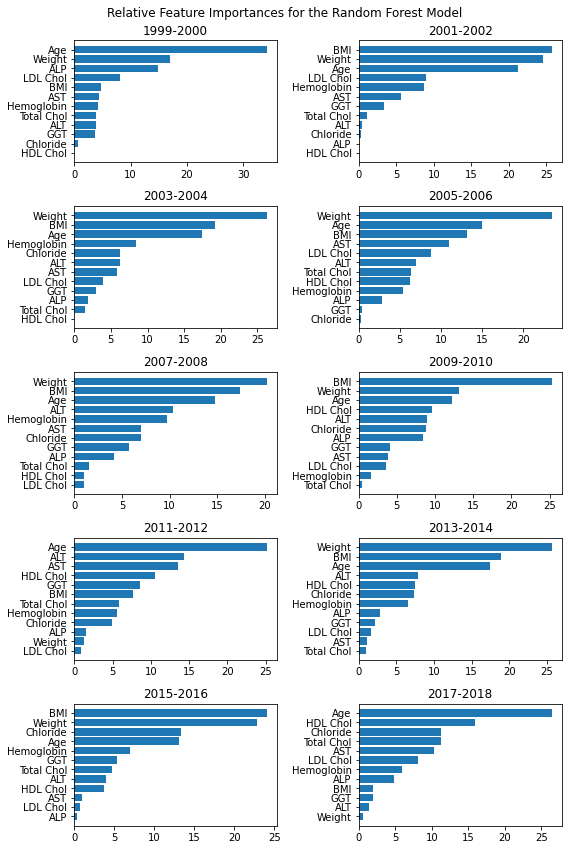

In [15]:
#Creating barcharts showing feature importances for the Random Forest Model for each cycle
fig, ax = plt.subplots(5,2, figsize=(8,12))

for a, (k,v) in zip(ax.flatten(), feature_importance_dict.items()):
        feat_importances = pd.Series(v,feature_names).sort_values(ascending=False)
        a.barh(feat_importances.index[::-1], feat_importances.values[::-1])
        a.set(title=k.strip('df_'))
        plt.tight_layout()
        fig.suptitle('Relative Feature Importances for the Random Forest Model')

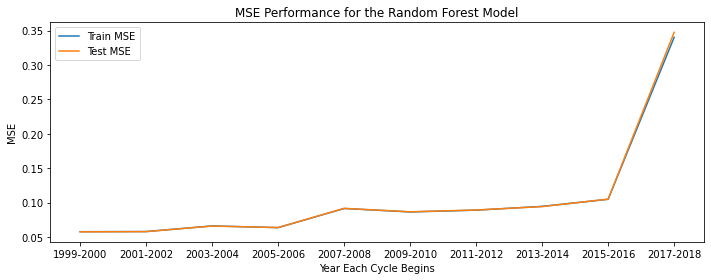

In [16]:
#plotting MSEs for the Random Forest model over each cycle for the train and test sets
train_mse = []
test_mse = []
cycle_list = []
for cycle, cycle_v in mse_dict.items():
    for k, v in cycle_v.items():
        if k == 'Train MSE':
            train_mse.append(v)
        elif k == 'Test MSE':
            test_mse.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, train_mse, label='Train MSE')
plt.plot(cycle_list, test_mse, label='Test MSE')
plt.title('MSE Performance for the Random Forest Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

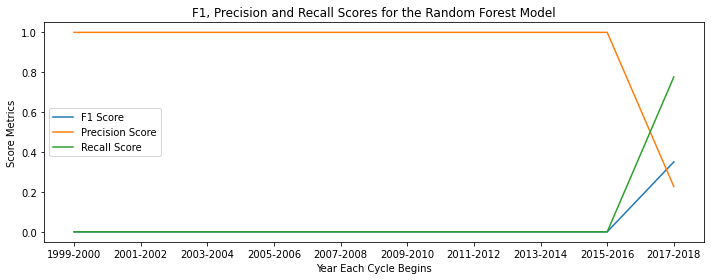

In [17]:
#plotting F1, Precision and Recall for the Random Forest model over each cycle
f1_list = []
precision_list = []
recall_list = []
cycle_list = []
for cycle, cycle_v in perf_metrics.items():
    for k, v in cycle_v.items():
        if k == 'F1':
            f1_list.append(v)
        elif k == 'Precision':
            precision_list.append(v)
        elif k == 'Recall':
            recall_list.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, f1_list, label='F1 Score')
plt.plot(cycle_list, precision_list, label='Precision Score')
plt.plot(cycle_list, recall_list, label='Recall Score')
plt.title('F1, Precision and Recall Scores for the Random Forest Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Score Metrics')
plt.legend()
plt.tight_layout()
plt.show()

## Random Forest

In [18]:
#This creates a random forest model for each cycle and storing the feature importances, MSEs in a dictionary

feature_importance_dict = {}
mse_dict = {}
perf_metrics = {}
for key, value in df_dict.items():
    df = value.drop(['SEQN','Year'], axis=1)
    X = df.drop('Diabetes', axis=1)
    y = df[['Diabetes']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #reshape y_train to be a column vector
    y_train = y_train.values.ravel()
    #Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    pipe = Pipeline([('scaler', StandardScaler()),('rf', rf)])
    param_grid = {'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [100, 200, 300]}
    rf_model = GridSearchCV(pipe, param_grid, cv=5)
    rf_model.fit(X_train, y_train)
    #feature importance
    feature_import = abs(rf_model.best_estimator_[1].feature_importances_)
    feature_import = 100 * feature_import / feature_import.sum()
    feature_importance_dict[key] = feature_import
    mse_dict[key] = {'Train MSE': round(mean_squared_error(y_train,rf_model.predict(X_train)),4),
                    'Test MSE': round(mean_squared_error(y_test,rf_model.predict(X_test)),4)}
    perf_metrics[key] = {'F1': round(f1_score(y_test,rf_model.predict(X_test)),4),
                        'Precision': round(precision_score(y_test,rf_model.predict(X_test)),4),
                        'Recall': round(recall_score(y_test,rf_model.predict(X_test)),4)}

c:\Users\jbrad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
#Creating feature names for graphs
feature_names = rf_model.best_estimator_.steps[0][1].feature_names_in_
feature_names

array(['Age', 'LDL Chol', 'HDL Chol', 'Chloride', 'Total Chol', 'GGT',
       'AST', 'Hemoglobin', 'Weight', 'BMI', 'ALP', 'ALT'], dtype=object)

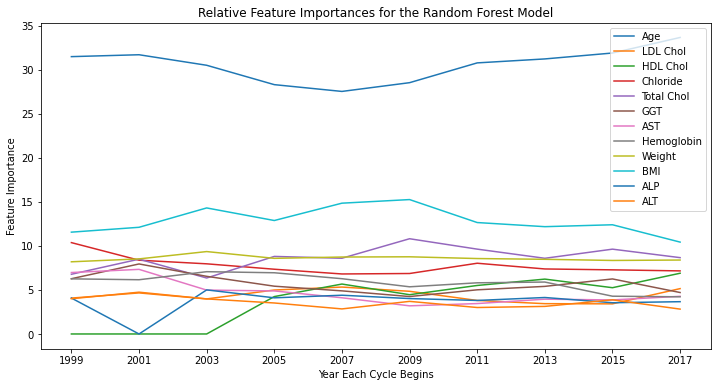

In [20]:
#plot feature importances for the random forest model over each cycle
plt.figure(figsize=(12,6))
plt.plot(['1999','2001','2003','2005','2007','2009','2011','2013','2015','2017'],feature_importance_dict.values())
plt.title('Relative Feature Importances for the Random Forest Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Feature Importance')
plt.legend(feature_names)
plt.show()

#Differing substantially from the Logistic Regression model, the Random Forest model had the top 2 feature importances (Age and BMI) stay
# in the top 2 positions throughout the cycles.
#There was some shifting near the bottom but the top 2 features stayed in the top 2 positions.

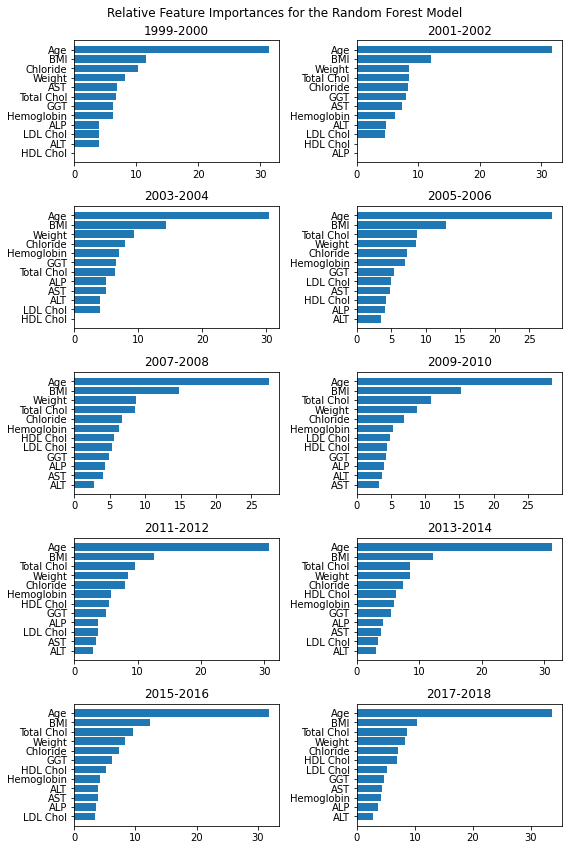

In [21]:
#Creating barcharts showing feature importances for the Random Forest Model for each cycle
fig, ax = plt.subplots(5,2, figsize=(8,12))

for a, (k,v) in zip(ax.flatten(), feature_importance_dict.items()):
        feat_importances = pd.Series(v,feature_names).sort_values(ascending=False)
        a.barh(feat_importances.index[::-1], feat_importances.values[::-1])
        a.set(title=k.strip('df_'))
        plt.tight_layout()
        fig.suptitle('Relative Feature Importances for the Random Forest Model')

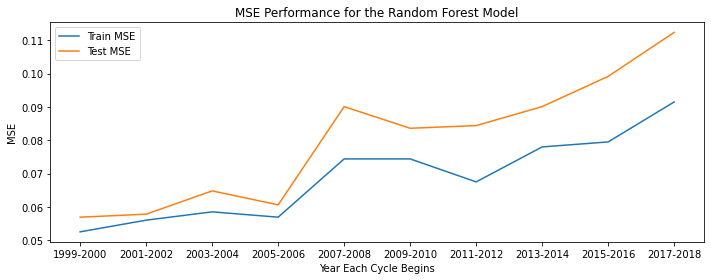

In [22]:
#plotting MSEs for the Random Forest model over each cycle for the train and test sets
train_mse = []
test_mse = []
cycle_list = []
for cycle, cycle_v in mse_dict.items():
    for k, v in cycle_v.items():
        if k == 'Train MSE':
            train_mse.append(v)
        elif k == 'Test MSE':
            test_mse.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, train_mse, label='Train MSE')
plt.plot(cycle_list, test_mse, label='Test MSE')
plt.title('MSE Performance for the Random Forest Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

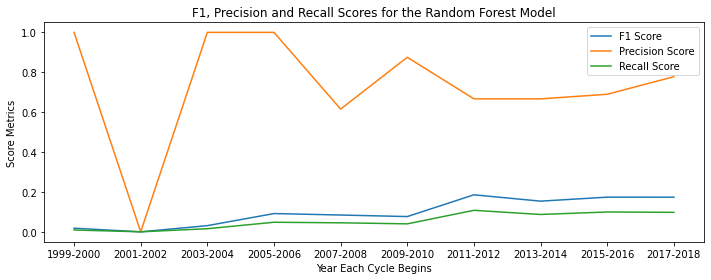

In [23]:
#plotting F1, Precision and Recall for the Random Forest model over each cycle
f1_list = []
precision_list = []
recall_list = []
cycle_list = []
for cycle, cycle_v in perf_metrics.items():
    for k, v in cycle_v.items():
        if k == 'F1':
            f1_list.append(v)
        elif k == 'Precision':
            precision_list.append(v)
        elif k == 'Recall':
            recall_list.append(v)
    cycle_list.append(cycle.strip('df_'))

plt.figure(figsize=(10,4))
plt.plot(cycle_list, f1_list, label='F1 Score')
plt.plot(cycle_list, precision_list, label='Precision Score')
plt.plot(cycle_list, recall_list, label='Recall Score')
plt.title('F1, Precision and Recall Scores for the Random Forest Model')
plt.xlabel('Year Each Cycle Begins')
plt.ylabel('Score Metrics')
plt.legend()
plt.tight_layout()
plt.show()